Domain x: (-3.141592653589793, 3.141592653589793)
Domain t: (0.0, 6.283185307179586)
x_train range: -3.0786008834838867 to 3.0786471366882324
t_train range: 0.06405356526374817 to 6.219579219818115
x_train does not touch boundaries: True
t_train does not touch boundaries: True


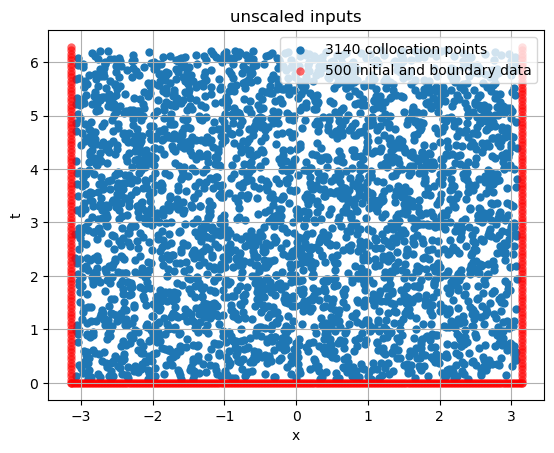

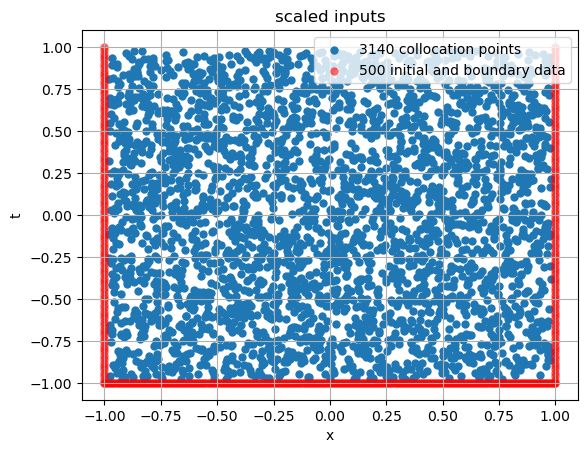

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.qmc import LatinHypercube
import time
import datetime

##############################################################################

# Generate Training Data
batch_size_interior = 3140
batch_size_bounds = 100
batch_size_initial = 300
domain_x_train = (-np.pi, np.pi)
domain_t_train = (0.0, 2*np.pi)

# Collocation points Nf
engine = LatinHypercube(d=2, seed=42)
sample = engine.random(n=batch_size_interior)

# Scaling factors to keep points within the domain but away from boundaries
scale_factor = 0.98  # For example, using 0.98 to keep it within the domain but not touching the boundary
shift_factor = 0.01  # Shift away from the boundary

x_train_dataset = (sample[:,1] * scale_factor + shift_factor) * (domain_x_train[1]-domain_x_train[0]) + domain_x_train[0]
t_train_dataset = (sample[:,0] * scale_factor + shift_factor) * (domain_t_train[1]-domain_t_train[0]) + domain_t_train[0]

x_train = x_train_dataset.copy().reshape(-1,1).astype(np.float32) # collocation points
t_train = t_train_dataset.copy().reshape(-1,1).astype(np.float32) # collocation points

def scale_inputs(x, x_min, x_max):
    return 2.0 * (x - x_min) / (x_max - x_min) - 1.0

# Apply this to x_train, t_train, etc.
x_train_scaled = scale_inputs(x_train, domain_x_train[0], domain_x_train[1])
t_train_scaled = scale_inputs(t_train, domain_t_train[0], domain_t_train[1])

# Print domain boundary values
print(f"Domain x: {domain_x_train}")
print(f"Domain t: {domain_t_train}")

# Check if x_train and t_train are within the boundaries
x_min, x_max = x_train.min(), x_train.max()
t_min, t_max = t_train.min(), t_train.max()

print(f"x_train range: {x_min} to {x_max}")
print(f"t_train range: {t_min} to {t_max}")

# Verification
x_within_bounds = (x_min > domain_x_train[0]) and (x_max < domain_x_train[1])
t_within_bounds = (t_min > domain_t_train[0]) and (t_max < domain_t_train[1])

print(f"x_train does not touch boundaries: {x_within_bounds}")
print(f"t_train does not touch boundaries: {t_within_bounds}")

# boundary data points
t_train_bounds = np.linspace(domain_t_train[0], domain_t_train[1], batch_size_bounds).reshape(-1,1).astype(np.float32)
x_train_left = np.full_like(t_train_bounds, domain_x_train[0])
x_train_right = np.full_like(t_train_bounds, domain_x_train[1])

t_train_bounds_scaled = scale_inputs(t_train_bounds, domain_t_train[0], domain_t_train[1])
x_train_left_scaled = scale_inputs(x_train_left, domain_x_train[0], domain_x_train[1])
x_train_right_scaled = scale_inputs(x_train_right, domain_x_train[0], domain_x_train[1])

# initial data points
def u_0(x):
    w = 1.0
    return (w/np.pi)**0.25 * np.exp(-w*x**2/2.0)

def u_1(x):
    w=1
    return (w/np.pi)**0.25 * np.exp(-w*x**2/2.0) * x*np.sqrt(w)

x_train_initial = np.linspace(domain_x_train[0], domain_x_train[1], batch_size_initial).reshape(-1,1).astype(np.float32)
t_train_initial = np.full_like(x_train_initial, domain_t_train[0])
u_train_initial = (1.0/np.sqrt(2.0)) * (u_0(x_train_initial) + u_1(x_train_initial))

x_train_initial_scaled = scale_inputs(x_train_initial, domain_x_train[0], domain_x_train[1])
t_train_initial_scaled = scale_inputs(t_train_initial, domain_t_train[0], domain_t_train[1])

# u_train_initial = u_train_initial.astype(np.complex64)

# plotting collocation and initial points
plt.scatter(x_train, t_train, alpha=1, linewidths=1e-6, label=f'{batch_size_interior} collocation points')
plt.scatter(x_train_left, t_train_bounds, color='red', alpha=0.6, linewidths=1e-6, label=f'{batch_size_initial+batch_size_bounds*2} initial and boundary data')
plt.scatter(x_train_right, t_train_bounds, color='red', alpha=0.6, linewidths=1e-6)
plt.scatter(x_train_initial, t_train_initial, color='red', alpha=0.6, linewidths=1e-6)
plt.xlabel('x')
plt.ylabel('t')
plt.title('unscaled inputs')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# plotting collocation and initial points
plt.scatter(x_train_scaled, t_train_scaled, alpha=1, linewidths=1e-6, label=f'{batch_size_interior} collocation points')
plt.scatter(x_train_left_scaled, t_train_bounds_scaled, color='red', alpha=0.6, linewidths=1e-6, label=f'{batch_size_initial+batch_size_bounds*2} initial and boundary data')
plt.scatter(x_train_right_scaled, t_train_bounds_scaled, color='red', alpha=0.6, linewidths=1e-6)
plt.scatter(x_train_initial_scaled, t_train_initial_scaled, color='red', alpha=0.6, linewidths=1e-6)
plt.xlabel('x')
plt.ylabel('t')
plt.title('scaled inputs')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

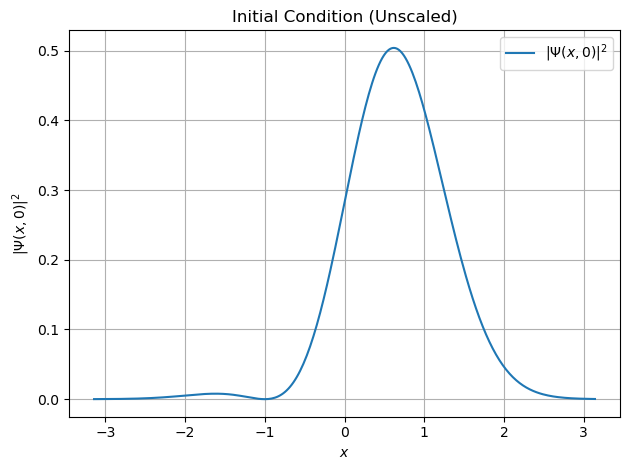

In [2]:
plt.plot(x_train_initial.flatten(), u_train_initial.flatten()**2, label=r'$|\Psi(x,0)|^2$')
plt.xlabel(r'$x$')
plt.ylabel(r'$|\Psi(x,0)|^2$')
plt.title('Initial Condition (Unscaled)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
##############################################################################

# Define the Neural Network
@tf.keras.utils.register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, **kwargs):
        super(PINN, self).__init__(**kwargs)
        initializer = tf.keras.initializers.HeNormal()
        self.dense1 = tf.keras.layers.Dense(256, activation='tanh', kernel_initializer=initializer)
        self.dense2 = tf.keras.layers.Dense(256, activation='tanh', kernel_initializer=initializer)
        self.dense3 = tf.keras.layers.Dense(256, activation='tanh', kernel_initializer=initializer)
        self.dense4 = tf.keras.layers.Dense(256, activation='tanh', kernel_initializer=initializer)
        self.dense5 = tf.keras.layers.Dense(2, activation='linear', kernel_initializer=initializer) # u_Re, u_Im
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)
        return x
    
    def get_config(self):
        config = super(PINN, self).get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# We use Hartree atomic units \hbar = m = 1
# Define the Physics Loss
def physics_loss(model, x_f, t_f):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x_f, t_f])

        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x_f, t_f])
            u = model(tf.concat([x_f, t_f], axis=1))
            u_Re, u_Im = u[..., 0], u[..., 1]
        
        u_Re_x = tape2.gradient(u_Re, x_f)
        u_Im_x = tape2.gradient(u_Im, x_f)

    u_Re_xx = tape1.gradient(u_Re_x, x_f)
    u_Im_xx = tape1.gradient(u_Im_x, x_f)

    u_Re_t = tape1.gradient(u_Re, t_f)
    u_Im_t = tape1.gradient(u_Im, t_f)

    w = 1.0
    V = 0.5 * w**2 * x_f**2

    # residual loss
    f_Re = -u_Im_t + 0.5*u_Re_xx - V*u_Re
    f_Im = u_Re_t + 0.5*u_Im_xx - V*u_Im
    
    loss = tf.square(f_Re) + tf.square(f_Im)
    
    return tf.reduce_mean(loss)

def boundary_condition(model, x_f, t_f):
    u = model(tf.concat([x_f, t_f], axis=1))
    u_Re, u_Im = u[..., 0], u[..., 1]

    loss = tf.square(u_Re - 0.0) + tf.square(u_Im - 0.0)

    return tf.reduce_mean(loss)

def initial_condition(model, x_f, t_f, u_data):
    u = model(tf.concat([x_f, t_f], axis=1))
    u_Re, u_Im = u[..., 0], u[..., 1]
    
    loss= tf.square(u_Re - tf.math.real(u_data)) + tf.square(u_Im - 0.0)
    
    return tf.reduce_mean(loss)

In [4]:
# Instantiate the Model
pinn = PINN()

with tf.device('/cpu:0'):  # for visibility on some systems
    sample_inputs = tf.concat([x_train_scaled[:5], t_train_scaled[:5]], axis=1)
    initial_preds = pinn(sample_inputs)
    print("Initial predictions:", initial_preds.numpy())

Initial predictions: [[-0.01273102 -0.87232304]
 [-0.5713131   0.36756295]
 [ 0.47762507 -0.77057195]
 [ 0.17991835  0.74091154]
 [ 0.47994184 -0.642311  ]]


Epoch 0: Loss = 8.824504852294922
Model saved to interrupted_Schrodinger_equation_v0.keras
Epoch 100: Loss = 2.0544888973236084
Model saved to interrupted_Schrodinger_equation_v0.keras
Epoch 200: Loss = 1.3664370775222778
Model saved to interrupted_Schrodinger_equation_v0.keras
Epoch 300: Loss = 0.479985773563385
Model saved to interrupted_Schrodinger_equation_v0.keras
Epoch 400: Loss = 0.3183888792991638
Model saved to interrupted_Schrodinger_equation_v0.keras
Epoch 500: Loss = 0.29624229669570923
Model saved to interrupted_Schrodinger_equation_v0.keras
Epoch 600: Loss = 0.32936257123947144
Model saved to interrupted_Schrodinger_equation_v0.keras
Epoch 700: Loss = 0.08748136460781097
Model saved to interrupted_Schrodinger_equation_v0.keras
Epoch 800: Loss = 0.08337961882352829
Model saved to interrupted_Schrodinger_equation_v0.keras
Epoch 900: Loss = 0.08594638854265213
Model saved to interrupted_Schrodinger_equation_v0.keras
Epoch 1000: Loss = 0.08504951000213623
Model saved to inter

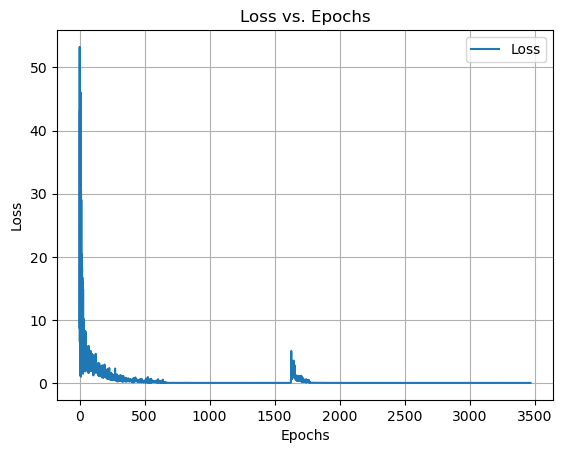

Model saved to Schrodinger_equation_v0.keras

Weights match.
Weights match.
Weights match.
Weights match.
Weights match.
Weights match.
Weights match.
Weights match.
Weights match.
Weights match.
Predictions match.


In [5]:
#############################################################################

# Instantiate the Model
pinn = PINN()

# Define the Optimizer
# Learning rate schedule with exponential decay
initial_learning_rate = 0.001
decay_rate = 0.9
decay_steps = 2000

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

# ADAM optimizer with beta1 = 0.09, beta2 = 0.999 (unusual but from paper)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    beta_1=0.09,
    beta_2=0.999,
    epsilon=1e-07,
    clipnorm=1.0
)

# Training Step Function
@tf.function
def train_step(x_train_scaled, t_train_scaled, x_train_initial_scaled, t_train_initial_scaled, u_train_initial, x_train_left_scaled, x_train_right_scaled, t_train_bounds_scaled):
    with tf.GradientTape() as tape:
        pde_loss = physics_loss(pinn, x_train_scaled, t_train_scaled)
        initial_loss = initial_condition(pinn, x_train_initial_scaled, t_train_initial_scaled, u_train_initial)
        bc_left_loss = boundary_condition(pinn, x_train_left_scaled, t_train_bounds_scaled)
        bc_right_loss = boundary_condition(pinn, x_train_right_scaled, t_train_bounds_scaled)
        loss = pde_loss + initial_loss + bc_left_loss + bc_right_loss
        
    gradients = tape.gradient(loss, pinn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, pinn.trainable_variables))
    return loss

#############################################################################

# List to store the loss values
loss_history = []
epoch_history = [0,]

# Define the loss threshold
loss_threshold = 1e-3

# Early stopping
early_stopping_patience = 500
best_loss = float('inf')
patience_counter = 0

# Start the timer
start_time = time.time()

# Training Loop until loss < loss_threshold
epoch = 0
while True:
    loss = train_step(x_train_scaled, t_train_scaled, x_train_initial_scaled, t_train_initial_scaled, u_train_initial, x_train_left_scaled, x_train_right_scaled, t_train_bounds_scaled)
    loss_value = loss.numpy()
    loss_history.append(loss_value)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.numpy()}")
        
        # Save the model in Keras format
        model_save_path_0 = "interrupted_Schrodinger_equation_v0.keras"
        pinn.save(model_save_path_0)
        print(f"Model saved to {model_save_path_0}")
        
    if loss_value < best_loss:
        best_loss = loss_value
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch} as loss did not improve for {early_stopping_patience} epochs.")
        print(f"Training stopped at epoch {epoch} with loss {loss_value}")
        break
    
    if loss_value < loss_threshold:
        print(f"Training stopped at epoch {epoch} as loss reached {loss_value}")
        break
    
    epoch += 1
    epoch_history.append(epoch)

# End the timer
end_time = time.time()

# Calculate total execution time
execution_time = end_time - start_time

# Convert to hours, minutes, seconds
execution_time_formatted = str(datetime.timedelta(seconds=int(execution_time)))

print(f"Total training time: {execution_time_formatted}")
        
# Plot the Loss vs. Epochs
plt.plot(epoch_history, loss_history, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Save the model in Keras format
model_save_path = "Schrodinger_equation_v0.keras"
pinn.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Save original weights
original_weights = pinn.get_weights()

# Load the model
loaded_pinn = tf.keras.models.load_model(model_save_path, custom_objects={'PINN': PINN})

# Check if the weights match
loaded_weights = loaded_pinn.get_weights()

for orig, loaded in zip(original_weights, loaded_weights):
    if not np.array_equal(orig, loaded):
        print("Weights do not match after loading!")
    else:
        print("Weights match.")

# Check prediction consistency
x_test = np.linspace(domain_x_train[0], domain_x_train[1], 100).reshape(-1,1).astype(np.float32)
t_test = np.linspace(domain_t_train[0], domain_t_train[1], 100).reshape(-1,1).astype(np.float32)

x_test_tensor = tf.convert_to_tensor(x_test)
t_test_tensor = tf.convert_to_tensor(t_test)

original_prediction = pinn(tf.concat([x_test_tensor, t_test_tensor], axis=1)).numpy()
loaded_prediction = loaded_pinn(tf.concat([x_test_tensor, t_test_tensor], axis=1)).numpy()

if not np.allclose(original_prediction, loaded_prediction, atol=1e-5):
    print("Predictions do not match after loading!")
else:
    print("Predictions match.")

Model loaded successfully


Model: "pinn_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (3140, 256)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (3140, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (3140, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (3140, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (3140, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,658 (776.01 KB)

 Trainable params: 198,658 (776.01 KB)

 Non-trainable params: 0 (0.00 B)

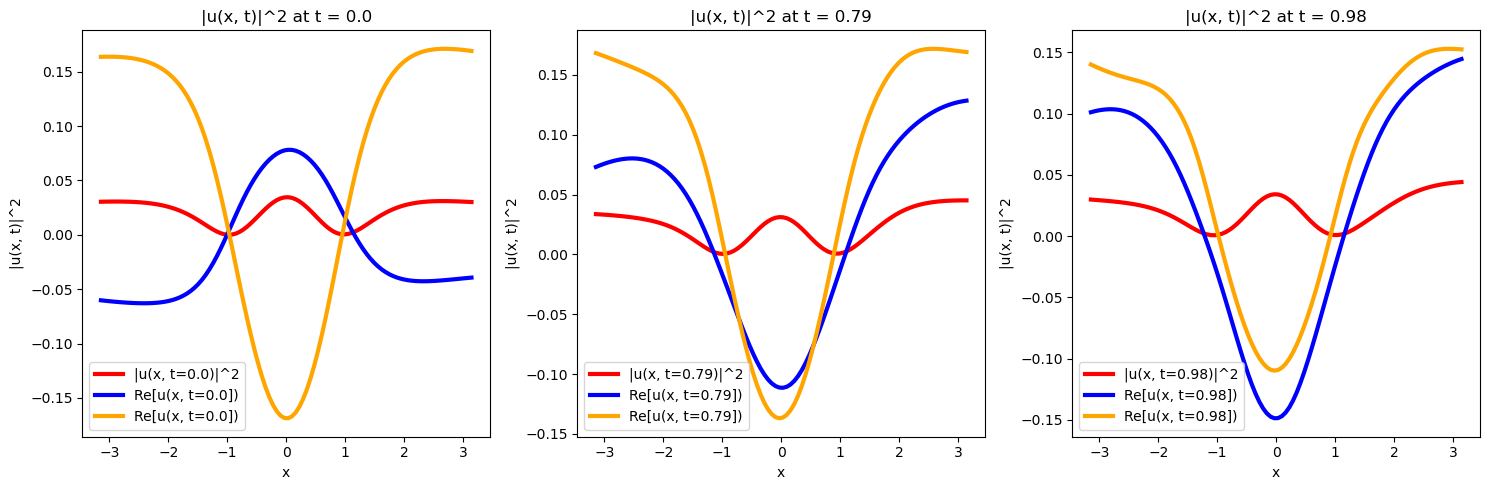

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define the Neural Network
@tf.keras.utils.register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, **kwargs):
        super(PINN, self).__init__(**kwargs)
        initializer = tf.keras.initializers.HeNormal()
        self.dense1 = tf.keras.layers.Dense(256, activation='tanh', kernel_initializer=initializer)
        self.dense2 = tf.keras.layers.Dense(256, activation='tanh', kernel_initializer=initializer)
        self.dense3 = tf.keras.layers.Dense(256, activation='tanh', kernel_initializer=initializer)
        self.dense4 = tf.keras.layers.Dense(256, activation='tanh', kernel_initializer=initializer)
        self.dense5 = tf.keras.layers.Dense(2, activation='linear', kernel_initializer=initializer) # u_Re, u_Im
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)
        return x
    
    def get_config(self):
        config = super(PINN, self).get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Load the model
loaded_model = tf.keras.models.load_model('Schrodinger_equation_v0.keras', custom_objects={'PINN': PINN})
print("Model loaded successfully")

loaded_model.summary()

# plotting
domain_x_train = (-np.pi, np.pi)
domain_t_train = (0.0, 2.0*np.pi)

# Define specific time values for plotting
t_specific_values = [0.0, 0.79, 0.98]  # Change these values as desired

# Generate x values for plotting
x_plot = np.linspace(domain_x_train[0], domain_x_train[1], 100).reshape(-1, 1).astype(np.float32)

# Set up the subplot grid
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Loop over each t_specific value to generate and plot the solution
for i, t_specific in enumerate(t_specific_values):
    # Create an array of the same shape as x with the specific time t
    t_plot = np.full_like(x_plot, t_specific)

    # Convert to tensors
    x_plot_tensor = tf.convert_to_tensor(x_plot)
    t_plot_tensor = tf.convert_to_tensor(t_plot)

    # Get predictions
    u_plot = loaded_model(tf.concat([x_plot_tensor, t_plot_tensor], axis=1)).numpy()
    u_plot_Re, u_plot_Im = u_plot[..., 0], u_plot[..., 1]
    u_plot_norm = tf.square(u_plot_Re) + tf.square(u_plot_Im)

    # Plot u(x, t_specific) versus x
    axes[i].plot(x_plot, u_plot_norm, color='red', linewidth=3, label=f'|u(x, t={t_specific})|^2')
    axes[i].plot(x_plot, u_plot_Re, color='blue', linewidth=3, label=f'Re[u(x, t={t_specific}])')
    axes[i].plot(x_plot, u_plot_Im, color='orange', linewidth=3, label=f'Re[u(x, t={t_specific}])')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('|u(x, t)|^2')
    axes[i].set_title(f'|u(x, t)|^2 at t = {t_specific}')
    axes[i].legend()
#     axes[i].grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()